In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.hub
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import time
import copy
import os
from tqdm import tqdm
import pandas as pd

os.makedirs('outputs/activation_maps', exist_ok=True)
os.makedirs('outputs/tsne', exist_ok=True)
os.makedirs('outputs/plots', exist_ok=True)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.7 * len(train_val_dataset))
val_size = int(0.1 * len(train_val_dataset))
remaining = len(train_val_dataset) - train_size - val_size
train_dataset, val_dataset, _ = random_split(train_val_dataset, [train_size, val_size, remaining])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def initialize_model(model_name, num_classes=10, pretrained=False):
    if model_name == "alexnet":
        model = models.alexnet(pretrained=pretrained)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Unsupported model name")
    return model

models_to_train = ['alexnet', 'resnet50']
trained_models = {}

In [5]:
for model_name in models_to_train:
    print(f"\nInitializing {model_name}...")
    model = initialize_model(model_name, num_classes=10, pretrained=False)
    model = model.to(device)
    trained_models[model_name] = {
        'model': model,
        'history': {
            'train_loss': [],
            'val_loss': []
        },
        'best_model_wts': copy.deepcopy(model.state_dict()),
        'best_val_loss': float('inf'),
        'train_times': 0,
        'num_epochs': 0
    }
    print(f"\nModel Summary for {model_name}:")
    if model_name == 'resnet50':
        summary(model, (3, 224, 224))
    else:
        summary(model, (3, 224, 224))


Initializing alexnet...


/home/bmi-lab/anaconda3/envs/ecg_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bmi-lab/anaconda3/envs/ecg_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Model Summary for alexnet:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvg

In [6]:
def train_model(model_info, model_name, num_epochs=30, patience=5):
    model = model_info['model']
    history = model_info['history']
    best_val_loss = model_info['best_val_loss']
    best_model_wts = model_info['best_model_wts']
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    since = time.time()
    epochs_no_improve = 0
    early_stop = False
    
    for epoch in range(num_epochs):
        if early_stop:
            print("Early stopping triggered.")
            break
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'{phase.capitalize()}')
            for batch_idx, (inputs, labels) in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                pbar.set_postfix({'Loss': loss.item()})
            
            epoch_loss = running_loss / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}')

            if phase == 'val':
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print(f"Validation loss did not improve for {patience} epochs. Stopping.")
                        early_stop = True
                        break
        
        model_info['best_val_loss'] = best_val_loss
        model_info['best_model_wts'] = best_model_wts
        model_info['num_epochs'] = epoch + 1
    
    time_elapsed = time.time() - since
    model_info['train_times'] = time_elapsed
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    model.load_state_dict(best_model_wts)
    model_info['model'] = model
    
    return model_info


In [8]:
num_epochs = 30
patience = 5

for model_name in models_to_train:
    print(f"\nStarting training for {model_name}...")
    trained_models[model_name] = train_model(trained_models[model_name], model_name, num_epochs=num_epochs, patience=patience)



Starting training for alexnet...

Epoch 1/30
----------


Train: 100%|██████████| 547/547 [00:12<00:00, 42.92it/s, Loss=0.243] 

Train Loss: 0.2256



Val: 100%|██████████| 79/79 [00:01<00:00, 49.27it/s, Loss=0.779]

Val Loss: 0.6785

Epoch 2/30
----------



Train: 100%|██████████| 547/547 [00:12<00:00, 43.12it/s, Loss=0.222] 

Train Loss: 0.2062



Val: 100%|██████████| 79/79 [00:01<00:00, 49.88it/s, Loss=1.25] 

Val Loss: 0.7184

Epoch 3/30
----------



Train: 100%|██████████| 547/547 [00:12<00:00, 43.35it/s, Loss=0.275] 

Train Loss: 0.1891



Val: 100%|██████████| 79/79 [00:01<00:00, 49.74it/s, Loss=2.17] 

Val Loss: 0.7249

Epoch 4/30
----------



Train: 100%|██████████| 547/547 [00:12<00:00, 43.06it/s, Loss=0.288] 

Train Loss: 0.1783



Val: 100%|██████████| 79/79 [00:01<00:00, 49.98it/s, Loss=1.04] 

Val Loss: 0.7105

Epoch 5/30
----------



Train: 100%|██████████| 547/547 [00:12<00:00, 43.20it/s, Loss=0.152] 

Train Loss: 0.1652



Val: 100%|██████████| 79/79 [00:01<00:00, 50.36it/s, Loss=0.323]

Val Loss: 0.7250
Validation loss did not improve for 5 epochs. Stopping.
Early stopping triggered.

Training complete in 1m 12s
Best Validation Loss: 0.6123

Starting training for resnet50...

Epoch 1/30
----------



Train: 100%|██████████| 547/547 [01:17<00:00,  7.06it/s, Loss=1.53]

Train Loss: 2.0566



Val: 100%|██████████| 79/79 [00:04<00:00, 19.65it/s, Loss=1.7] 


Val Loss: 3.4556

Epoch 2/30
----------


Train: 100%|██████████| 547/547 [01:17<00:00,  7.08it/s, Loss=1.32]

Train Loss: 1.4569



Val: 100%|██████████| 79/79 [00:03<00:00, 19.92it/s, Loss=1.04] 

Val Loss: 1.2616

Epoch 3/30
----------



Train: 100%|██████████| 547/547 [01:16<00:00,  7.13it/s, Loss=1.18] 

Train Loss: 1.2006



Val: 100%|██████████| 79/79 [00:04<00:00, 19.63it/s, Loss=1.06] 

Val Loss: 1.2033

Epoch 4/30
----------



Train: 100%|██████████| 547/547 [01:17<00:00,  7.05it/s, Loss=0.993]

Train Loss: 0.9887



Val: 100%|██████████| 79/79 [00:04<00:00, 19.63it/s, Loss=1.16] 

Val Loss: 1.0111

Epoch 5/30
----------



Train: 100%|██████████| 547/547 [01:16<00:00,  7.15it/s, Loss=0.612]

Train Loss: 0.8283



Val: 100%|██████████| 79/79 [00:03<00:00, 19.83it/s, Loss=1.14] 

Val Loss: 0.8356

Epoch 6/30
----------



Train: 100%|██████████| 547/547 [01:16<00:00,  7.15it/s, Loss=0.607]

Train Loss: 0.6772



Val: 100%|██████████| 79/79 [00:04<00:00, 19.74it/s, Loss=1.41] 

Val Loss: 0.7967

Epoch 7/30
----------



Train: 100%|██████████| 547/547 [01:16<00:00,  7.12it/s, Loss=0.546]

Train Loss: 0.5509



Val: 100%|██████████| 79/79 [00:03<00:00, 19.95it/s, Loss=0.927]

Val Loss: 0.8300

Epoch 8/30
----------



Train: 100%|██████████| 547/547 [01:16<00:00,  7.16it/s, Loss=0.515]

Train Loss: 0.4380



Val: 100%|██████████| 79/79 [00:03<00:00, 19.99it/s, Loss=0.317]

Val Loss: 0.8403

Epoch 9/30
----------



Train: 100%|██████████| 547/547 [01:16<00:00,  7.12it/s, Loss=0.24]  

Train Loss: 0.3363



Val: 100%|██████████| 79/79 [00:03<00:00, 19.96it/s, Loss=1.34] 

Val Loss: 0.9677

Epoch 10/30
----------



Train: 100%|██████████| 547/547 [01:16<00:00,  7.16it/s, Loss=0.252] 

Train Loss: 0.2730



Val: 100%|██████████| 79/79 [00:03<00:00, 20.01it/s, Loss=0.938]

Val Loss: 1.1111

Epoch 11/30
----------



Train: 100%|██████████| 547/547 [01:16<00:00,  7.15it/s, Loss=0.389] 

Train Loss: 0.2164



Val: 100%|██████████| 79/79 [00:03<00:00, 19.96it/s, Loss=0.163]

Val Loss: 0.9052
Validation loss did not improve for 5 epochs. Stopping.
Early stopping triggered.

Training complete in 14m 50s
Best Validation Loss: 0.7967


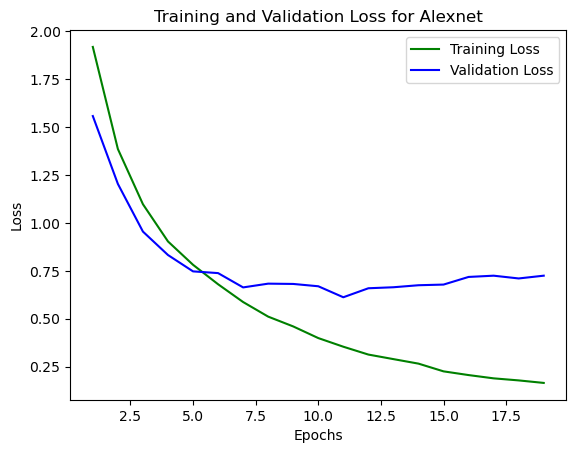

In [10]:
# Adjust epochs to match the length of the loss data
num_epochs = len(history['train_loss'])
epochs = range(1, num_epochs + 1)

# Plot the data
plt.figure()
plt.plot(epochs, history['train_loss'], 'g-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'b-', label='Validation Loss')
plt.title(f'Training and Validation Loss for {model_name.capitalize()}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
def evaluate_model(model, dataloader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

test_results = {}

for model_name in models_to_train:
    print(f"\nEvaluating {model_name} on test data...")
    model = trained_models[model_name]['model']
    test_loss, test_accuracy = evaluate_model(model, test_loader)
    test_results[model_name] = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



Evaluating alexnet on test data...
Test Loss: 0.6257, Test Accuracy: 79.78%

Evaluating resnet50 on test data...
Test Loss: 0.8158, Test Accuracy: 72.14%


In [16]:
def visualize_activations(model, model_name, layer_names, num_images=1, num_features=8):
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from torchvision.transforms.functional import to_pil_image

    os.makedirs(f'outputs/activation_maps', exist_ok=True)

    activation = {}
    hooks = []

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    for name, layer in layer_names.items():
        hooks.append(layer.register_forward_hook(get_activation(name)))

    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images = images[:num_images].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(images)

    for hook in hooks:
        hook.remove()

    img = images[0].cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                  np.array([0.485, 0.456, 0.406]), 0, 1)

    num_layers = len(layer_names)
    plt.figure(figsize=(20, 10))

    plt.subplot(num_layers + 1, num_features, 1)
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')

    for idx, (name, act) in enumerate(activation.items()):
        act = act[0].cpu()
        act = act[:num_features]

        for i in range(act.shape[0]):
            plt.subplot(num_layers + 1, num_features, (idx * num_features) + i + 2)
            plt.imshow(act[i], cmap='viridis')
            plt.axis('off')

            if idx == 0:
                plt.title(f'{name} [{i}]')

    plt.tight_layout()
    plt.savefig(f'outputs/activation_maps/{model_name}_activations.png', dpi=300)
    plt.show()




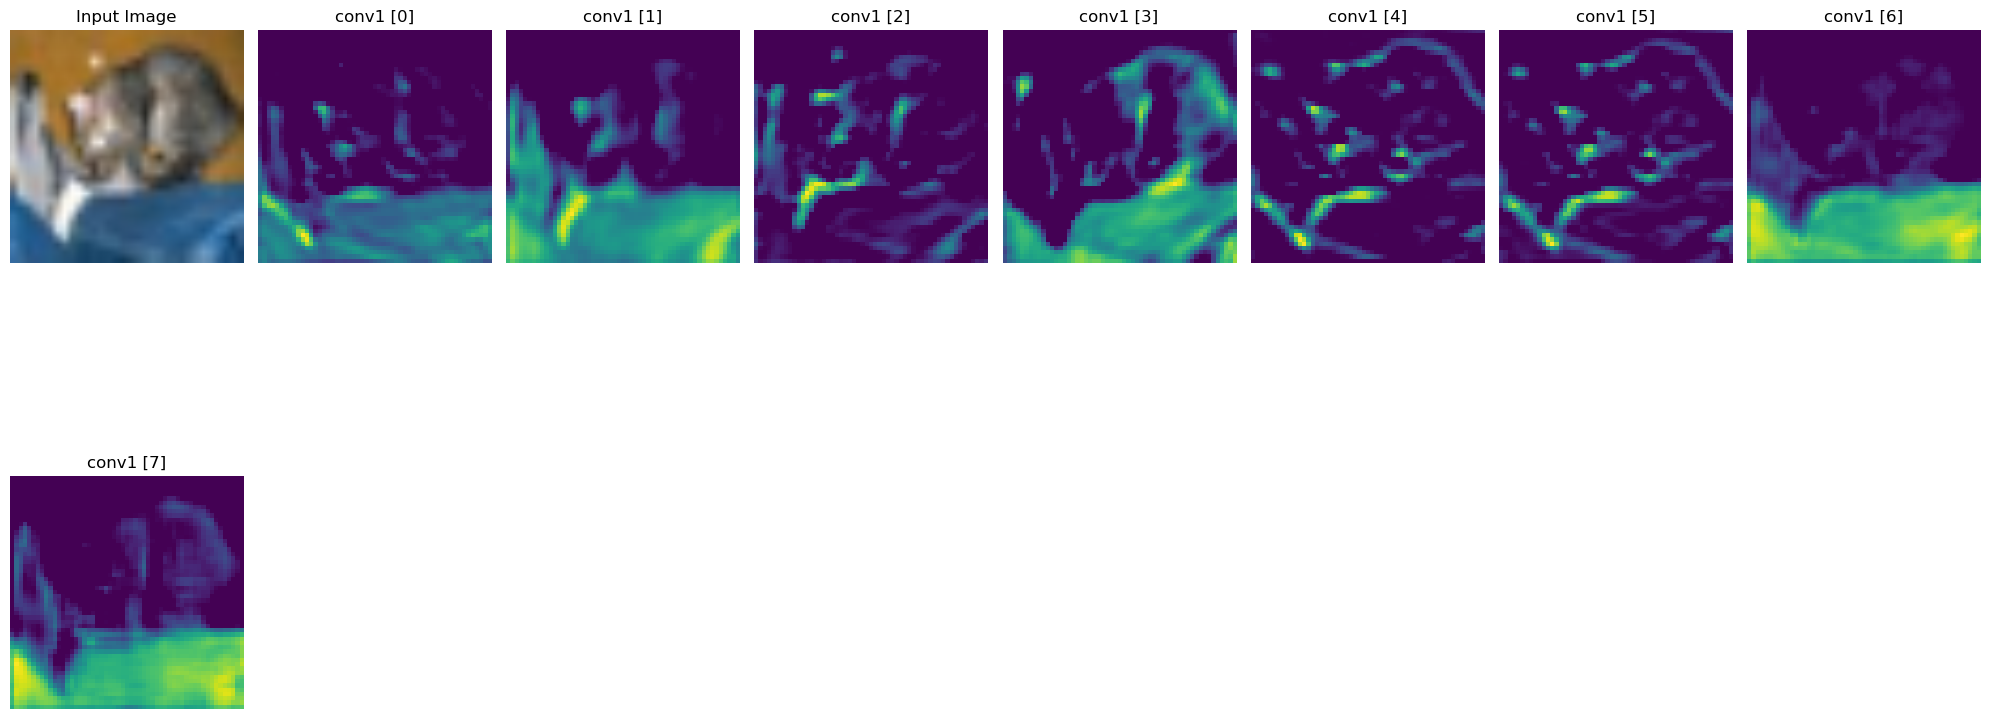

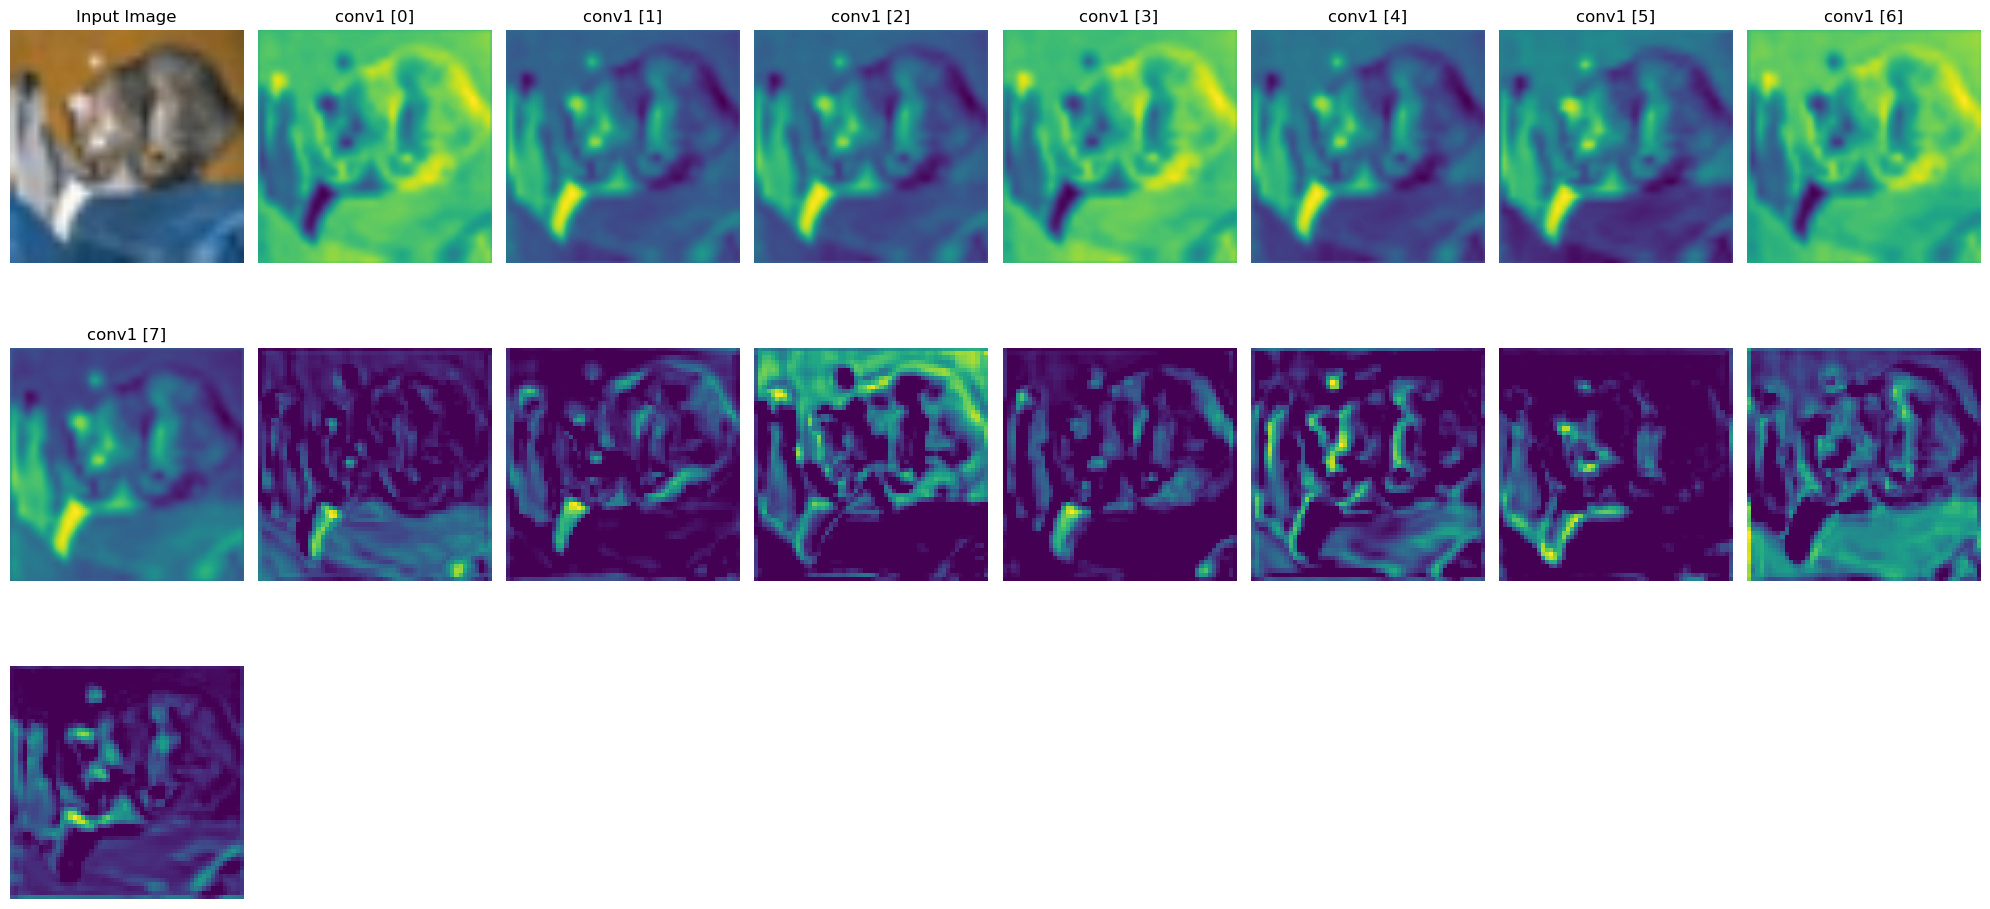

In [17]:
activation_layers = {
    'conv1': None,
    'layer1': None
}

for model_name in models_to_train:
    model = trained_models[model_name]['model']
    if model_name == 'alexnet':
        activation_layers['conv1'] = model.features[0]
        activation_layers_to_use = {'conv1': activation_layers['conv1']}
    elif model_name == 'resnet50':
        activation_layers['conv1'] = model.conv1
        activation_layers['layer1'] = model.layer1
        activation_layers_to_use = {
            'conv1': activation_layers['conv1'],
            'layer1': activation_layers['layer1']
        }
    visualize_activations(model, model_name, activation_layers_to_use)

In [21]:
def get_bottleneck_features(model, dataloader, layer_name):
    model.eval()
    features = []
    labels = []
    hooks = []
    activation = {}
    
    def hook_fn(module, input, output):
        activation['bottleneck'] = output.detach()

    for name, layer in model.named_modules():
        if name == layer_name:
            hooks.append(layer.register_forward_hook(hook_fn))
            break

    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            bottleneck_output = activation['bottleneck'].cpu().numpy()

            if bottleneck_output.ndim == 4:
                bottleneck_output = bottleneck_output.reshape(bottleneck_output.shape[0], -1)
            
            features.append(bottleneck_output)
            labels.extend(lbls.numpy())

    for hook in hooks:
        hook.remove()

    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    return features, labels


In [22]:
def tsne_visualization(features, labels, title, filename):
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
    plt.gca().add_artist(legend1)
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.savefig(filename, dpi=300)
    plt.show()



Performing t-SNE for alexnet...


/home/bmi-lab/anaconda3/envs/ecg_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bmi-lab/anaconda3/envs/ecg_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


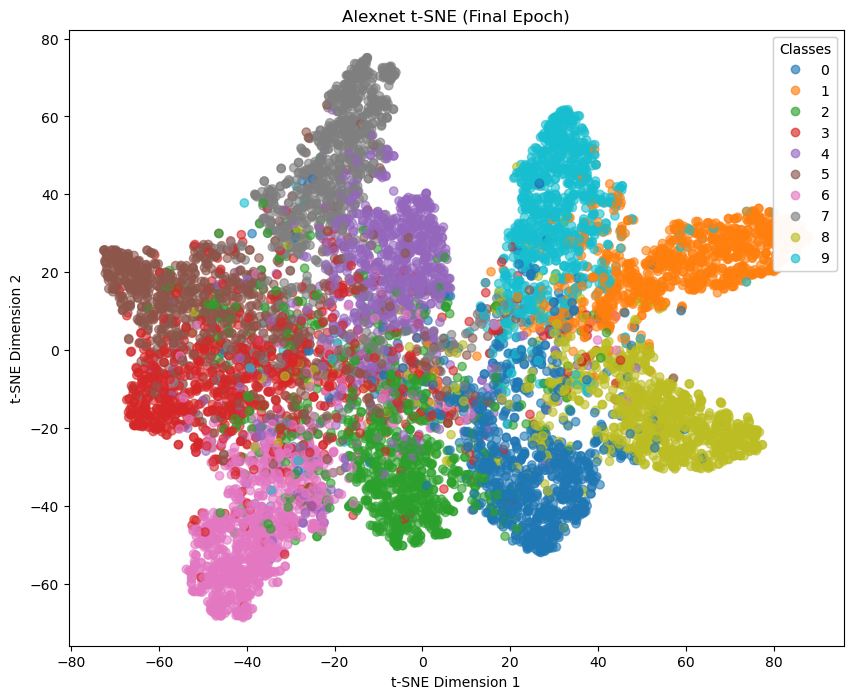


Performing t-SNE for resnet50...


/home/bmi-lab/anaconda3/envs/ecg_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bmi-lab/anaconda3/envs/ecg_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


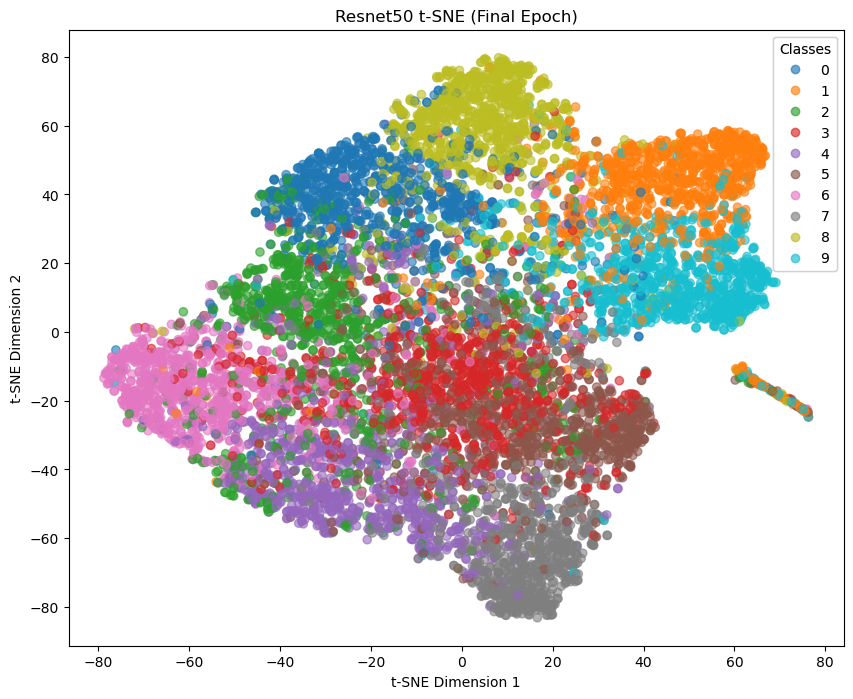

In [23]:
for model_name in models_to_train:
    model = trained_models[model_name]['model']
    
    if model_name == 'alexnet':
        bottleneck_layer = 'classifier.5'
    elif model_name == 'resnet50':
        bottleneck_layer = 'avgpool'
    
    print(f"\nPerforming t-SNE for {model_name}...")
    
    temp_model = initialize_model(model_name, num_classes=10, pretrained=False).to(device)
    temp_model.load_state_dict(trained_models[model_name]['model'].state_dict())

    features, labels = get_bottleneck_features(model, test_loader, bottleneck_layer)
    tsne_visualization(features, labels, f'{model_name.capitalize()} t-SNE (Final Epoch)', 
                      f'outputs/tsne/{model_name}_tsne_final.png')

In [ ]:
print("\nModel Performance Comparison:")
comparison_table = []

for model_name in models_to_train:
    accuracy = test_results[model_name]['test_accuracy']
    epochs = trained_models[model_name]['num_epochs']
    train_time = trained_models[model_name]['train_times']
    model = trained_models[model_name]['model']
    num_params = sum(p.numel() for p in model.parameters())
    
    comparison_table.append([model_name.capitalize(), accuracy, epochs, train_time, num_params])



df = pd.DataFrame(comparison_table, columns=['Model', 'Test Accuracy (%)', 'Epochs', 'Training Time (s)', 'Parameters'])
print(df)

df.to_csv('outputs/comparison_table.csv', index=False)


Model Performance Comparison:
      Model  Test Accuracy (%)  Epochs  Training Time (s)  Parameters
0   Alexnet              79.78       5          71.724523    57044810
1  Resnet50              72.14      11         889.813223    23528522


In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('surname/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('surname/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['surname/names/Portuguese.txt', 'surname/names/French.txt', 'surname/names/German.txt', 'surname/names/Japanese.txt', 'surname/names/Vietnamese.txt', 'surname/names/English.txt', 'surname/names/Czech.txt', 'surname/names/Irish.txt', 'surname/names/Chinese.txt', 'surname/names/Russian.txt', 'surname/names/Italian.txt', 'surname/names/Dutch.txt', 'surname/names/Arabic.txt', 'surname/names/Spanish.txt', 'surname/names/Scottish.txt', 'surname/names/Korean.txt', 'surname/names/Greek.txt', 'surname/names/Polish.txt']
Slusarski


In [2]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [4]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [5]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7436, -2.9521, -2.9148, -2.8948, -2.7642, -2.9691, -2.8224, -2.8493,
         -2.8628, -2.8771, -2.8446, -2.9602, -2.9397, -2.8958, -2.9122, -2.9524,
         -2.9604, -2.9506]], grad_fn=<LogSoftmaxBackward0>)


In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 0)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Nero
category = Greek / line = Calpis
category = Dutch / line = Rooiakker
category = Vietnamese / line = Le
category = Spanish / line = Elizondo
category = Greek / line = Blades
category = Korean / line = Wang
category = Arabic / line = Nader
category = Czech / line = Kudrna
category = Arabic / line = Khoury


In [9]:
criterion = nn.NLLLoss()

In [12]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 4.9977 Jelen / Dutch ✗ (Polish)
10000 10% (0m 7s) 0.0755 Albani / Italian ✓
15000 15% (0m 10s) 0.6088 Madaidhin / Irish ✓
20000 20% (0m 14s) 2.7867 Philips / Greek ✗ (Dutch)
25000 25% (0m 17s) 0.0993 Than / Vietnamese ✓
30000 30% (0m 21s) 0.8103 Ma / Korean ✓
35000 35% (0m 24s) 1.1070 Voss / German ✓
40000 40% (0m 28s) 1.1841 Koole / Dutch ✓
45000 45% (0m 31s) 3.8503 Dunkle / Scottish ✗ (German)
50000 50% (0m 35s) 1.4793 Nadwornik / Dutch ✗ (Czech)
55000 55% (0m 38s) 0.7308 Spiker / Dutch ✓
60000 60% (0m 42s) 0.1445 Baik / Korean ✓
65000 65% (0m 46s) 0.3741 Szwedko / Polish ✓
70000 70% (0m 49s) 2.3950 Ton / Chinese ✗ (Vietnamese)
75000 75% (0m 53s) 0.8673 Lennon / Irish ✓
80000 80% (0m 56s) 0.9703 Columbo / Italian ✓
85000 85% (1m 0s) 1.5360 Martin / French ✗ (Scottish)
90000 90% (1m 3s) 0.0041 Dioletis / Greek ✓
95000 95% (1m 7s) 7.3028 Rovbel / French ✗ (Russian)
100000 100% (1m 10s) 0.0092 Bellincioni / Italian ✓


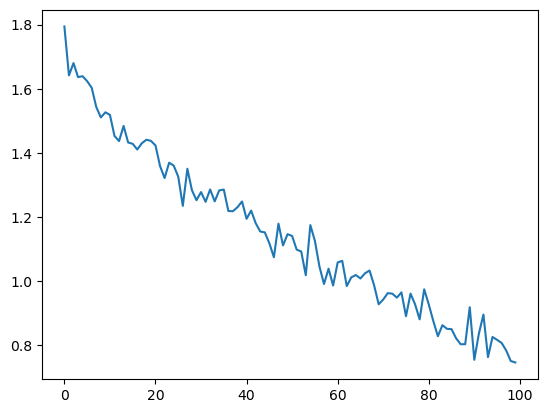

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_2046046/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_2046046/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


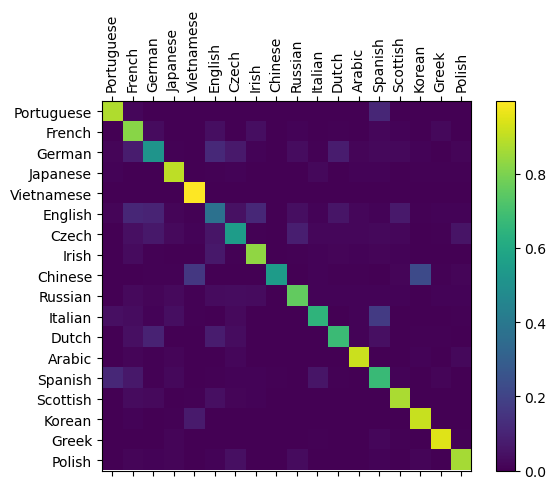

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [19]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = self.fc(output[-1])  # Take the last time step
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

n_hidden = 128
gru = GRUModel(n_letters, n_hidden, n_categories)

In [20]:
def train(category_tensor, line_tensor):
    hidden = gru.initHidden()

    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i].unsqueeze(0), hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in gru.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


In [ ]:
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# Plotting the Results
plt.figure()
plt.plot(all_losses)
plt.show()

# Evaluating the Results
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = gru.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i].unsqueeze(0), hidden)
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Running on User Input
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

5000 5% (0m 26s) 2.9547 Seow / Japanese ✗ (Chinese)
10000 10% (0m 51s) 2.8439 Riese / Dutch ✗ (German)
15000 15% (1m 17s) 2.5798 Arthur / German ✗ (French)
20000 20% (1m 43s) 3.1670 Boulos / Greek ✗ (Arabic)


In [ ]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [ ]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = gru.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i].unsqueeze(0), hidden)
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()